In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

In [2]:
preco = yf.download('VALE3.SA', period = '5y' , auto_adjust=True)[['Close']]
log_retorno = np.log(preco.Close) - np.log(preco.Close.shift(1))
log_retorno.dropna(inplace = True)

[*********************100%%**********************]  1 of 1 completed


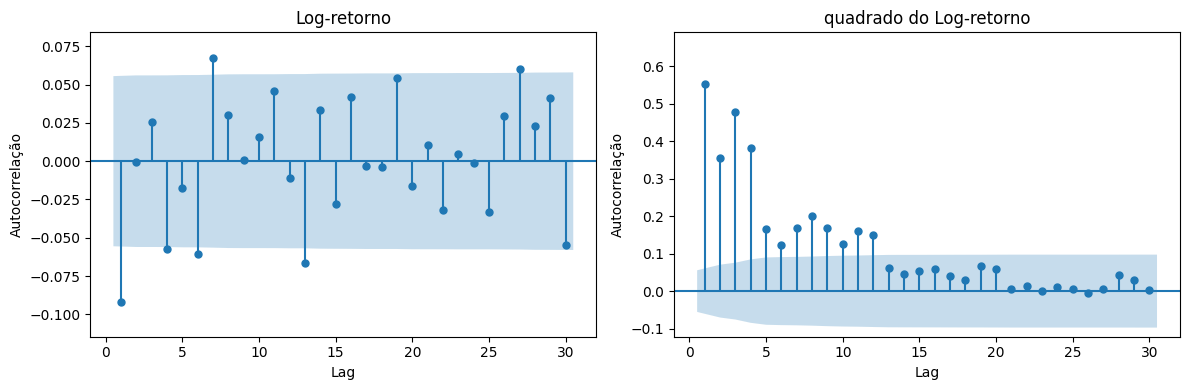

In [3]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

#
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(log_retorno.values, lags=30, ax=ax[0], zero = False, auto_ylims = True)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelação')
ax[0].set_title('Log-retorno')
# Gráfico de autocorrelação
sm.graphics.tsa.plot_acf(log_retorno.values**2, lags=30, ax=ax[1], zero = False, auto_ylims = True)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Autocorrelação')
ax[1].set_title('quadrado do Log-retorno')

plt.tight_layout()
plt.show()

In [4]:
from arch import arch_model

# Cria o modelo e realiza o ajuste
garch = arch_model(log_retorno * 100, p = 1, q = 1, mean = 'AR', vol = 'GARCH', dist = 'skewstudent').fit(disp = 'off')
garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                
=========================================================================================
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                                   AR   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -2624.77
Distribution:      Standardized Skew Student's t   AIC:                           5261.54
Method:                       Maximum Likelihood   BIC:                           5292.30
                                                   No. Observations:                 1244
Date:                           Sun, Nov 10 2024   Df Residuals:                     1243
Time:                                   20:13:45   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.0787  5.557e-02      1.415      0.157 [-3.027e-02,  0.188]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1596  8.335e-02      1.915  5.550e-02 [-3.751e-03,  0.323]
alpha[1]       0.0921  2.710e-02      3.400  6.748e-04  [3.902e-02,  0.145]
beta[1]        0.8789  3.694e-02     23.792 4.010e-125    [  0.806,  0.951]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
eta            5.8459      0.878      6.658  2.780e-11   [  4.125,  7.567]
lambda         0.1064  3.818e-02      2.786  5.334e-03 [3.154e-02,  0.181]
==========================================================================

Covariance estimator: robust
"""

In [5]:
vol_cond = pd.DataFrame(garch.conditional_volatility * np.sqrt(252)).reset_index()
vol_cond['Date'] = pd.to_datetime(vol_cond['Date'])


In [6]:
import plotly.graph_objects as go

fig = go.Figure()
# Adicionando a linha de volatilidade condicional
fig.add_trace(go.Scatter(x=vol_cond['Date'],
                         y=vol_cond['cond_vol'],
                         mode='lines',
                         name="Volatilidade Condicional"
                         ))
fig.update_layout(title="Volatilidade Anualizada - GARCH(1,1)",
                xaxis=dict(title="",
                            tickformat="%b/%Y",  # Formato de data para os rótulos do eixo x
                            dtick="M6"  # Intervalo de 6 meses
                            ),
                yaxis=dict(title="% a.a." ),
                annotations=[
                    dict(xref="paper", yref="paper",                                                
                        x=0.5, y=-0.2, showarrow=False)],
                width=1000,
                height=400,
                template="plotly_white", 
                legend=dict(orientation="h",
                            yanchor="top",
                            y=-0.3,
                            xanchor="center",
                            x=0.5
                            )
)

fig.show()


<Axes: title={'center': 'Residuos Padrozinados'}>

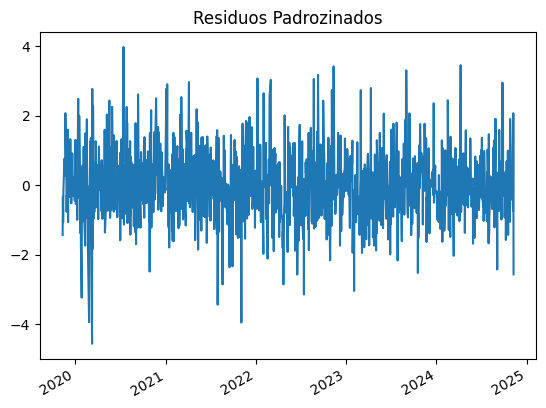

In [7]:
# resíduos
garch.std_resid.plot(title = 'Residuos Padrozinados', xlabel = '')


In [8]:
garch.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 577.1030
P-value: 0.0000
Distributed: chi2(23)
WaldTestStatistic, id: 0x7fc90f21c750

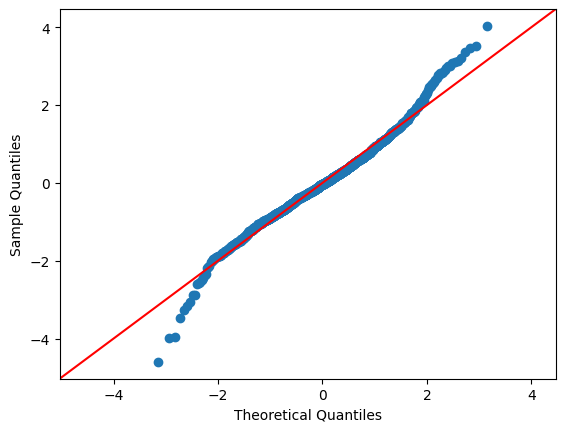

In [9]:
sm.graphics.qqplot(garch.std_resid, line='45', fit=True);

In [21]:
# volatilidade de longo prazo
def calculate_longterm_volatility(x):
    model = arch_model(x * 100, vol='Garch', p=1, q=1)
    result = model.fit(disp='off')
    params = result.params
    lt_variance = params["omega"] / (1 - params["alpha[1]"] - params["beta[1]"])
    return np.sqrt(lt_variance * 252)

lt_vols=log_retorno.rolling(window = 756).apply(calculate_longterm_volatility)
lt_vols.name='vol longo prazo (grach)'

sample_vols=((log_retorno.rolling(window = 756).std() * 100) * np.sqrt(252))
sample_vols.name = 'vol amostral (dp)'

vols = pd.concat([lt_vols, sample_vols], axis=1, join='inner')

In [26]:
vols=vols.dropna()

In [27]:
import plotly.graph_objects as go

# Criando o gráfico
fig = go.Figure()
fig.add_trace(go.Scatter(x=vols.index,y=vols['vol longo prazo (grach)'],
                         mode='lines', line=dict(color='red', width=0.7),name='garch longo prazo'))
fig.add_trace(go.Scatter(x=vols.index,y=vols['vol amostral (dp)'],
                         mode='lines', line=dict(color='blue', width=0.7),name='desvio padrao'))


# Configurando o layout do gráfico
fig.update_layout(
    title="Volatilidade Anualizada \n Volatilidade de Longo Prazo GARCH(1,1) x Volatilidade Amostral (Desvio Padrão)",
    xaxis=dict(
        title="",
        tickformat="%b/%Y",  # Formato de data para os rótulos do eixo x
        dtick="M3",  # Intervalo de 3 meses
    ),
    yaxis=dict(
        title="% a.a."
    ),
    annotations=[
        dict(
            text="Janelas Móveis de 3 anos",
            xref="paper", yref="paper",
            x=0.5, y=-0.15, showarrow=False
        ),
    ],
    width=1200,
    height=600,
    template="plotly_white",  # Tema minimalista
    legend=dict(
        orientation="h",  # Orientação horizontal
        yanchor="top",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

# Exibindo o gráfico
fig.show()
